In [1]:
!pip install vaderSentiment 
!pip install textblob 
!pip install nltk

  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl (125 kB)
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached charset_normalizer-3.4.1-cp39-cp39-win_amd64.whl (102 kB)
  Using cached certifi-2024.12.14-py3-none-any.whl (164 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl (128 kB)
  Using cached idna-3.10-py3-none-any.whl (70 kB)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached textblob-0.18.0.post0-py3-none-any.whl (626 kB)
  Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
  Using cached regex-2024.11.6-cp39-cp39-win_amd64.whl (274 kB)
  Using cached click-8.1.8-py3-none-any.whl (98 kB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [31]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\emrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
# Check if the resource is already downloaded to avoid redundancy
def download_nltk_resources(resources):
    for resource in resources:
        if not nltk.download(resource, quiet=True):
            print(f"Downloading NLTK resource: {resource}")
            nltk.download(resource)
        else:
            print(f"NLTK resource '{resource}' is already downloaded.")

resources_needed = ['stopwords', 'punkt']
download_nltk_resources(resources_needed)

# Set English stop words
stop_words = set(stopwords.words('english'))
print(f"Stop words set to English.")

NLTK resource 'stopwords' is already downloaded.
NLTK resource 'punkt' is already downloaded.
Stop words set to English.


## Data Exploration

| Column    | Description |
| ------------- | ----------|
| Overall | rating|
| verified |  the review is posted by a customer who did buy the product from Amazon and paid a normal price |
| reviewTime |  date where the review is posted |
| reviewerID |  userID |
| asin |  Amazon Standard Identification Number, a unique id for each product |
| reviewerName |  username |
| reviewText |  self-explanatory |
| summary |  short summary of reviewText |
| unixReviewTime |  review time in Unix Timestamp format |
| vote |  votes of the review |
| style |  a dictionary of product's metadata |
| image |  images posted by the reviewer after receiving the product |

In [13]:
data = pd.read_json('Video_Games_5.json', lines=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         497577 non-null  int64 
 1   verified        497577 non-null  bool  
 2   reviewTime      497577 non-null  object
 3   reviewerID      497577 non-null  object
 4   asin            497577 non-null  object
 5   reviewerName    497501 non-null  object
 6   reviewText      497419 non-null  object
 7   summary         497468 non-null  object
 8   unixReviewTime  497577 non-null  int64 
 9   vote            107793 non-null  object
 10  style           289237 non-null  object
 11  image           3634 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 42.2+ MB
None


In [14]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [15]:
#Check missing values per column
miss_val = data.isnull().sum()
miss_val=miss_val.drop(miss_val[miss_val == 0].index).sort_values(ascending = False)
display(pd.DataFrame({'Missing Values':miss_val, 'Percent':round(miss_val/len(data),2)*100}))

,Missing Values,Percent
image,493943,99.0
vote,389784,78.0
style,208340,42.0
reviewText,158,0.0
summary,109,0.0
reviewerName,76,0.0


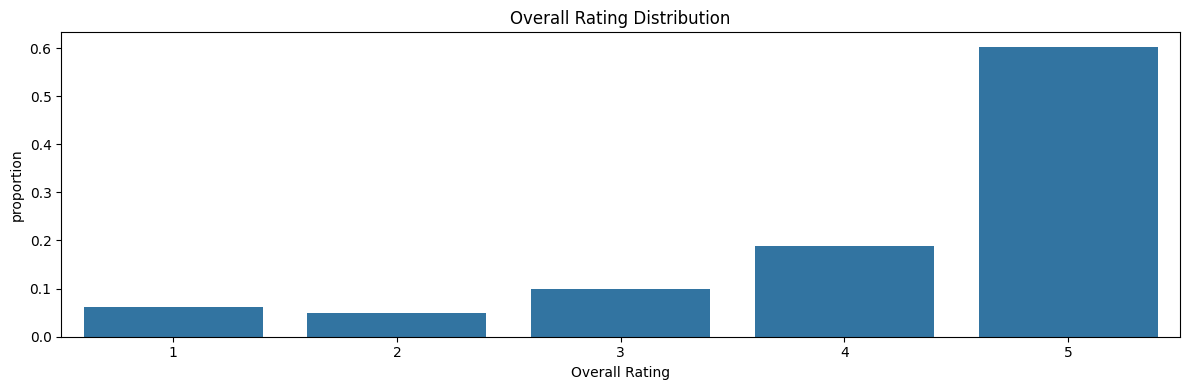

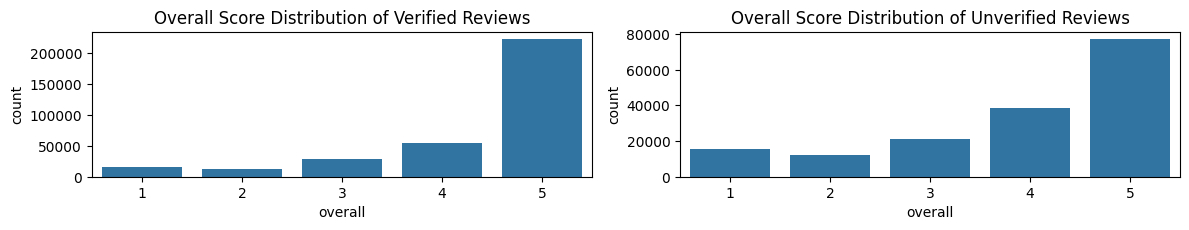

In [21]:
#Plotting the overall rating distribution
rating_counts = data['overall'].value_counts().reset_index()
rating_counts.columns = ['overall', 'count']
rating_counts['proportion'] = rating_counts['count']/rating_counts['count'].sum()

fig = plt.figure(figsize=(12,4))
plt.subplot(1,1,1)
sns.barplot(data=rating_counts,x='overall',y='proportion')
plt.title('Overall Rating Distribution')
plt.xlabel('Overall Rating')
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(12,4))
plt.subplot(2,2,1)
sns.barplot(x=data[data['verified']==True]['overall'].value_counts().index,
            y=data[data['verified']==True]['overall'].value_counts() )
plt.title('Overall Score Distribution of Verified Reviews')
plt.subplot(2,2,2)
sns.barplot(x=data[data['verified']==False]['overall'].value_counts().index,
            y=data[data['verified']==False]['overall'].value_counts() )
plt.title('Overall Score Distribution of Unverified Reviews')
plt.tight_layout()
plt.show()

In [22]:
rating_counts = data['overall'].value_counts()
print(f"Rating Counts: \n{rating_counts}\n")

average_rating = data['overall'].mean()
print(f"Average Rating: {average_rating:.2f}")

Rating Counts: 
overall
5    299759
4     93654
3     49146
1     30883
2     24135
Name: count, dtype: int64

Average Rating: 4.22


Distribution of Reviews Across Products: 
asin
B00178630A    1381
B000ZK9QCS     905
B000XJNTNS     834
B00JK00S0S     783
B000ZKA0J6     774
              ... 
B0017YHYFM       1
B000WKW6AU       1
B000XJD33E       1
B000WZ7OD4       1
B0011W8DNW       1
Name: count, Length: 17408, dtype: int64



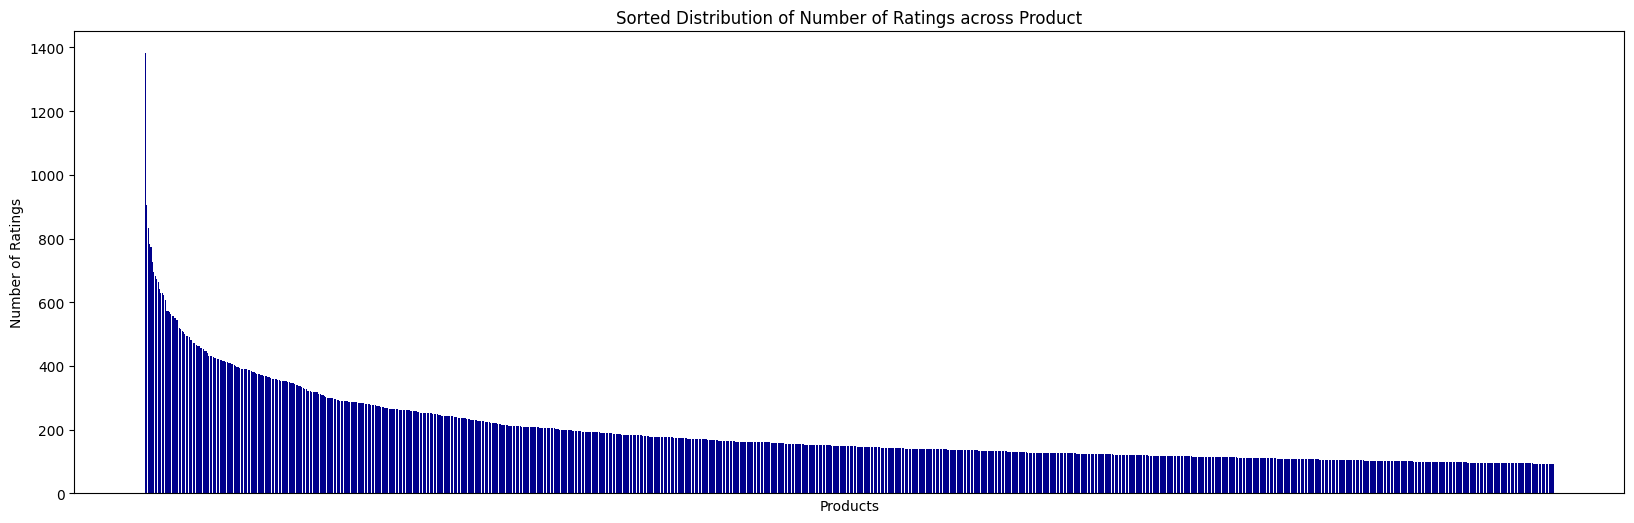

In [24]:
product_review_counts = data['asin'].value_counts()
print(f"Distribution of Reviews Across Products: \n{product_review_counts}\n")

plt.figure(figsize=(20,6))
plt.bar(product_review_counts.index[:1000],product_review_counts[:1000],color='darkblue')
plt.xlabel('Products')
plt.ylabel('Number of Ratings')
plt.title('Sorted Distribution of Number of Ratings across Product')
plt.xticks([])

plt.show()

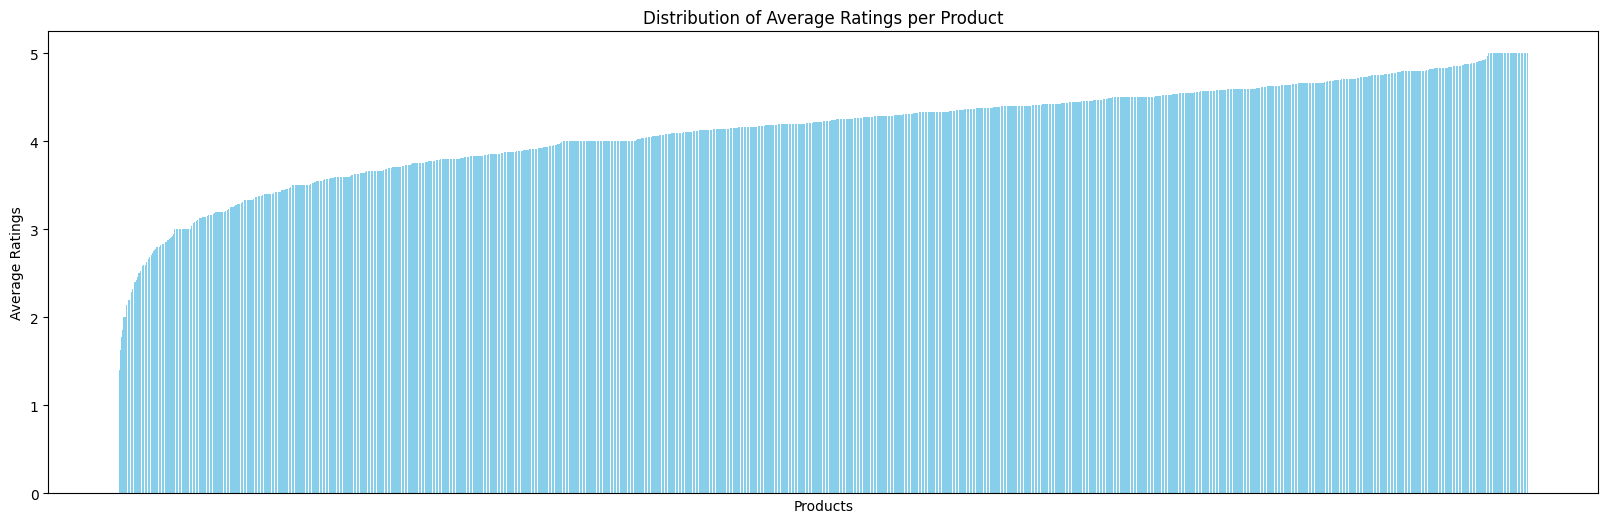

In [25]:
average_ratings_per_product = data.groupby('asin')['overall'].mean().sort_values()

plt.figure(figsize=(20,6))
plt.bar(average_ratings_per_product.index, average_ratings_per_product, color='skyblue')
plt.xlabel('Products')
plt.ylabel('Average Ratings')
plt.title('Distribution of Average Ratings per Product')
plt.xticks([]) 

plt.show()

Distribution of Reviews Per User: 
reviewerID
A3V6Z4RCDGRC44    815
AJKWF4W7QD4NS     795
A3W4D8XOGLWUN5    521
A2QHS1ZCIQOL7E    472
A2TCG2HV1VJP6V    453
                 ... 
A3TJT6OK2CNJQW      5
AP29MC4YEW1NL       5
A28C2PAK06VJ4L      4
A1I75X6T38Y4UW      4
A1HV707K7KWQP0      4
Name: count, Length: 55223, dtype: int64



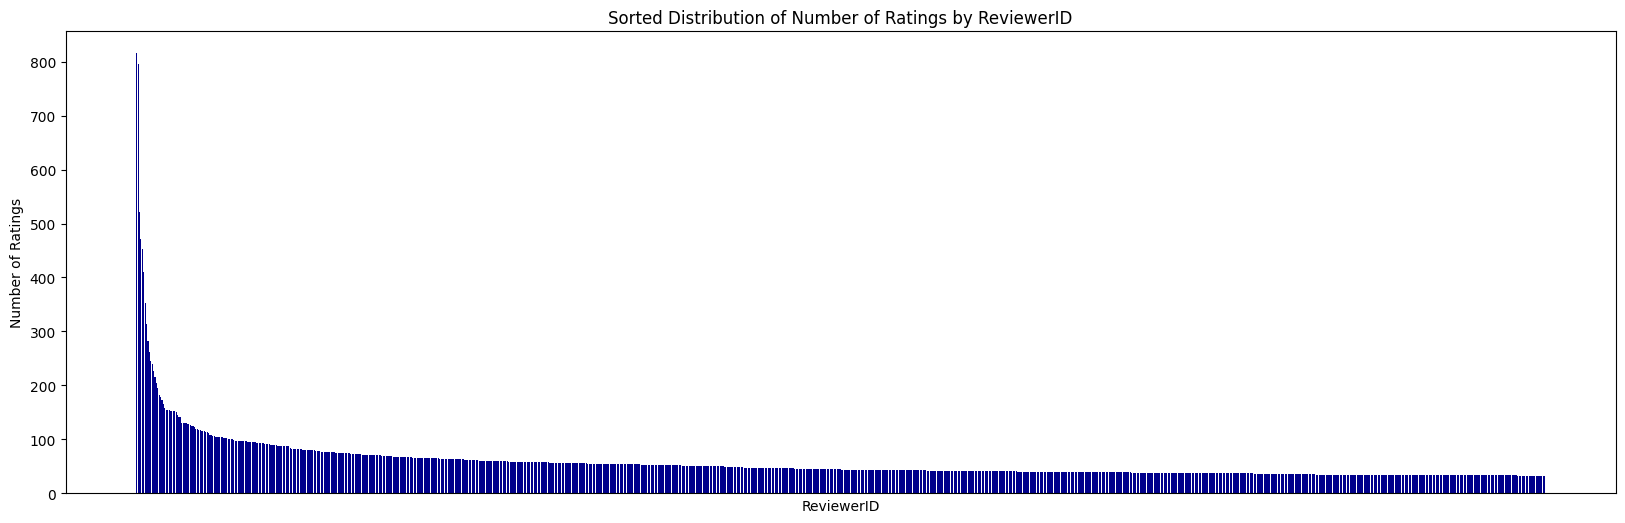

In [26]:
user_review_counts = data['reviewerID'].value_counts()
print(f"Distribution of Reviews Per User: \n{user_review_counts}\n")


plt.figure(figsize=(20,6))
plt.bar(user_review_counts.index[:1000], user_review_counts[:1000], color='darkblue')
plt.xlabel('ReviewerID')
plt.ylabel('Number of Ratings')
plt.title('Sorted Distribution of Number of Ratings by ReviewerID')
plt.xticks([])

plt.show()

In [27]:
#Top20 reviewers' average ratings and number of reviews
top20_reviewer=user_review_counts.head(20).index

for i in top20_reviewer:
  print("reviewerID: ", i)
  print("Average rating: ", data[data['reviewerID']==i].groupby('reviewerID')['overall'].mean().values)
  print("Number of reviews: ", data[data['reviewerID']==i].groupby('reviewerID')['overall'].count().values)
  print()

reviewerID:  A3V6Z4RCDGRC44
Average rating:  [4.29447853]
Number of reviews:  [815]

reviewerID:  AJKWF4W7QD4NS
Average rating:  [3.67672956]
Number of reviews:  [795]

reviewerID:  A3W4D8XOGLWUN5
Average rating:  [3.75815739]
Number of reviews:  [521]

reviewerID:  A2QHS1ZCIQOL7E
Average rating:  [3.66949153]
Number of reviews:  [472]

reviewerID:  A2TCG2HV1VJP6V
Average rating:  [4.0794702]
Number of reviews:  [453]

reviewerID:  A29BQ6B90Y1R5F
Average rating:  [4.20924574]
Number of reviews:  [411]

reviewerID:  A119Q9NFGVOEJZ
Average rating:  [5.]
Number of reviews:  [353]

reviewerID:  A2582KMXLK2P06
Average rating:  [3.55414013]
Number of reviews:  [314]

reviewerID:  A20DZX38KRBIT8
Average rating:  [3.29432624]
Number of reviews:  [282]

reviewerID:  A74TA8X5YQ7NE
Average rating:  [3.70610687]
Number of reviews:  [262]

reviewerID:  A3GKMQFL05Z79K
Average rating:  [4.5755102]
Number of reviews:  [245]

reviewerID:  A1AISPOIIHTHXX
Average rating:  [4.46861925]
Number of reviews: 

In [ ]:
data.dropna(subset=['reviewText'], inplace=True) #Drop reviews without reviewText

def tokenize_rm_stopwords_and_length(review):
    # Tokenize and remove stop words
    tokens = word_tokenize(review)

    filtered_tokens = [word for word in tokens if word not in stop_words]
    ## Join the tokens back into a string
    cleaned_text = ' '.join(filtered_tokens)

    cleaned_tokens = word_tokenize(cleaned_text)
    # The length of the cleaned text in terms of number of words
    length_of_cleaned_text = len(tokens)

    return length_of_cleaned_text,cleaned_text


In [33]:
data['reviewLength'] = data['reviewText'].apply(lambda x: len(x.split()))
data[['cleanedReviewLength', 'cleanedReview']] = data['reviewText'].apply(tokenize_rm_stopwords_and_length).apply(lambda x: pd.Series(x))

In [34]:
# Basic summary statistics
display(pd.DataFrame(data['reviewLength'].describe()))
display(pd.DataFrame(data['cleanedReviewLength'].describe()))

#records with min len
data[data['reviewLength']==data['reviewLength'].min()]

#records with max len counted by tokenization

data[data['cleanedReviewLength']==data['cleanedReviewLength'].max()]['reviewText'].values

,reviewLength
count,497419.000000
mean,122.696216
std,226.993931
min,1.000000
25%,11.000000
50%,40.000000
75%,132.000000
max,5928.000000


,cleanedReviewLength
count,497419.000000
mean,140.994668
std,261.773489
min,1.000000
25%,13.000000
50%,46.000000
75%,151.000000
max,7016.000000


array(['So here is the deal...\n\nI am reviewing the game, not the Steam Account annoyances or anyone personal computer issue, I will briefly comment on them at the end, but it is not necessary to read, and is not part of the \'review\' itself.\n\nTHIS IS A LONG REVIEW\nQuick points (I write detailed reviews, this is for those that don\'t wish to read it all):\n\n* Great graphics/visuals\n* Attention to detail is high\n* There is a polish to the game\n* Combat is reworked and is now real strategy\n* Happiness is changed and means more\n* The music could be better\n* The game is a \'step change\' from previous versions, but is still classic Civ\n* Culture is different and means more\n* Victory conditions have radically changed for the better\n* The game \'flows\' more and feels more organic\n* Will take SERIOUS getting used to, but will feel like \'good old Civ\' in no time\n* Must open mind to playing it\n* Remains vastly deep and complex, probably more than Civ 4, but better interface

In [35]:
# Remove unused columns first because the determination of duplicates needs hashable columns
data.drop(columns=['style','image','vote'],inplace=True)
# Remove duplicated rows
data.drop_duplicates(inplace=True)

In [36]:
data['user_and_asin'] = data['reviewerID'] + data['asin']

In [37]:
# Check records with same user and same ASIN
print(data['user_and_asin'].value_counts())

user_and_asin
A14KKV5U5XSHXYB00SN1QEGW    70
A71Z5AIGEFK11B00SN1QEGW     45
A8J2YHESWGF2EB014P7QI6I      6
AZQGB17PI6D3NB014P7QI6I      6
A2HYAYOI8XX1ITB014P7QI6I     6
                            ..
AVECM71LSZLC5B01HGPUTCA      1
A1RS06313BL6WNB01HH6JEOC     1
ACIZ77IGIX2JLB01HH6JEOC      1
A34GG58TJ1A3SHB01HIZF7XE     1
A2GPRA9HHLOC4B0700026398     1
Name: count, Length: 473270, dtype: int64


In [38]:
data[data['user_and_asin']=='A14KKV5U5XSHXYB00SN1QEGW']

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,reviewLength,cleanedReviewLength,cleanedReview,user_and_asin
390179,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,I much prefer this controller over the standar...,Should be the standard remote...,1533168000,34,41,I much prefer controller standard Wii Remote ....,A14KKV5U5XSHXYB00SN1QEGW
390180,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,This controller makes any game that supports i...,This controller makes any game that supports i...,1533168000,29,29,This controller makes game supports much playa...,A14KKV5U5XSHXYB00SN1QEGW
390181,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,Feels great in your hands and works very well....,Excellent!,1533168000,27,30,Feels great hands works well . It familiar des...,A14KKV5U5XSHXYB00SN1QEGW
390182,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,Bought this for super smash bros. It is a grea...,Does what it's supposed to,1533168000,40,45,Bought super smash bros . It great controller ...,A14KKV5U5XSHXYB00SN1QEGW
390183,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,Definitely one of my favorite controllers. Sym...,Five Stars,1533168000,67,77,Definitely one favorite controllers . Symmetri...,A14KKV5U5XSHXYB00SN1QEGW
...,...,...,...,...,...,...,...,...,...,...,...,...,...
390244,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,am so used to having the 2nd analog stick belo...,They ahd the best thing going with the gamecub...,1533168000,48,51,used 2nd analog stick buttons I could get used...,A14KKV5U5XSHXYB00SN1QEGW
390245,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,"Really pleased with this controller, so much n...",Really pleased with this controller,1533168000,47,54,"Really pleased controller , much nicer use gia...",A14KKV5U5XSHXYB00SN1QEGW
493403,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,Needed this as an accessory for Wii U as there...,Does the job!,1533168000,16,19,Needed accessory Wii U n't enough controllers ...,A14KKV5U5XSHXYB00SN1QEGW
493404,5,True,"08 2, 2018",A14KKV5U5XSHXY,B00SN1QEGW,Amazoncustomer,The control is beautiful . Super cmodo y preci...,The best control in the world.,1533168000,27,32,The control beautiful . Super cmodo preciso . ...,A14KKV5U5XSHXYB00SN1QEGW


**EDA Findings**

- Dataset is highly imbalanced, which should be considered during analysis.
- Some of the products receives significantly more reviews than most of the other products
- The average rating for most of the products is above 3
- Some of the users have hundreds of reviews; however, their ratings are not uniform
- There are outlier reviews in terms of their length
- There are reviews for the same product written by the same UserID on the same day and time. There could be system error, but won't affect the sentiment analysis

## Preprocessing

In [39]:
data['label'] = data['overall'].apply(lambda x: 'Positive' if x in (4,5) else ('Negative' if x in (1,2) else 'Neutral'))

In [40]:
data['label'].value_counts()

label
Positive    375486
Negative     51980
Neutral      46558
Name: count, dtype: int64

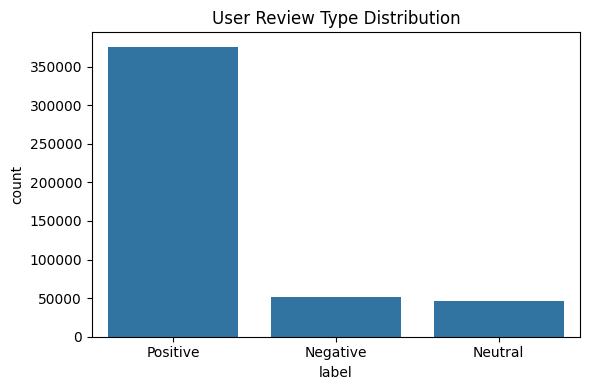

In [41]:
fig = plt.figure(figsize=(6,4))
sns.barplot(x=data['label'].value_counts().index, y=data['label'].value_counts())
plt.title('User Review Type Distribution')
plt.tight_layout()
plt.xlabel('label')
plt.ylabel('count')
plt.show()

In [42]:
def remove_punctuation(sentence):
    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    # Remove punctuation and lowercase the words
    words_without_punctuations = [word.lower() for word in words if word.isalnum()]

    return words_without_punctuations